The goal of this test is to see if two groups of GoCs (with stochastic current) have a similar spike activity in Brian2

In [1]:
from brian2 import *
from matplotlib import *
import numpy as np
import random
import pandas as pd
import os
import time

In [2]:
#Parameters Block
activeMF_fraction = 0.2 # Int, (decimal notion) fraction of active mossy fibers
activeMF_seed     = 451 # Int or None, if user wishes to seed the random active mossy fiber call

# Cell numbers to reproduce functionally relevant 100um^3 cube of granular layer
nmf  =  315                 # Mossy fibers
nGrC = 4096                 # Granule cells
nGoC =   27                 # Golgi cells

# Convergence ratios of connections (to determine connection probabilities)
conv_GrC_M   =   4          #  mf -> GrC synapses
conv_GoC_M   =  50          #  mf -> GoC synapses
conv_GoC_GrC = 100          # GrC -> GoC synapses
conv_GrC_GoC =   4          # Goc -> GrC synapses

# Leak conductance
g_l_GrC   = 0.4   * nS
g_t_GrC   = 0.4   * nS

g_l_GoC   = 3.    * nS

# Reversal potential (leak, excitatory, inhibitory)
E_l_GrC   = -75   * mV
E_e_GrC   =   0   * mV
E_i_GrC   = -75   * mV

E_l_GoC   = -50   * mV
E_e_GoC   =   0   * mV
E_i_GoC   = -75   * mV

# Membrane capacitance
C_m_GrC   =  3.1  * pF
C_m_GoC   = 60.   * pF

# TODO Use rise and decay times and add dyanmics to neuron Equations
tau_e_decay_GrC = 6.0 * ms
tau_e_decay_GoC = 3.0 * ms

tau_i_decay_GrC = 15.0 * ms

# Absolute refractory period
tau_r_GrC = 2 * ms
tau_r_GoC = 40* ms

# Spiking threshold
V_th_GrC   = -55 * mV
V_th_GoC   = -50 * mV

# Resting potential
V_r_GrC    = -75 * mV
V_r_GoC    = -55 * mV

# Golgi cell reset potential
V_reset_GoC = -60 * mV

# Synaptic weights
w_e_GrC = 0.65 * nS
w_i_GrC = 0.08 * nS

w_e_GoC_M = 0.35  * nS
w_e_GoC_GrC = 0.0 * nS

# Stochastic fluctuating excitatory current
sigma_n_GoC = 0.01 * nS
sigma_n_GrC = 0.03 * nS

tau_n   = 20 * ms

### Brian 2 Code (do not segment the following cell)

In [3]:
#Brian 2 Code Block

#neuron equations
GoC_eqs = '''
dv/dt   = (g_l*(E_l-v) + (g_e+g_n)*(E_e-v))/C_m : volt (unless refractory)
dg_e/dt = -g_e/tau_e : siemens
dg_n/dt = (-g_n + sigma_n_GoC * sqrt(tau_n) * xi)/tau_n : siemens
'''

# mossy fiber input
stim_times = [1010, 1020, 1030]            # Mossy fiber stimulation times
nstim      = len(stim_times)

# Randomly select a subset of mossy fibers to spike at each stimulation
# If you want a different subset of mossy fibers at each stimulation, move
# the declaration of [active_indices] into the loop over stim_times

if activeMF_seed is not None: np.random.seed(activeMF_seed) #seed value
active_indices = sorted(np.random.choice(nmf, round(nmf * activeMF_fraction), replace=False)) 
indices    = []
times      = []
for j in range(nstim):
    indices.extend(active_indices)
    times.extend([stim_times[j]]*len(active_indices))
times    = times * ms
mf_input = SpikeGeneratorGroup(nmf, indices, times)

#neurons 
GoC1 = NeuronGroup(nGoC,
                   Equations(GoC_eqs,
                             g_l = g_l_GoC,
                             E_l = E_l_GoC,
                             E_e = E_e_GoC,
                             E_i = E_i_GoC,
                             C_m = C_m_GoC,
                             tau_e = tau_e_decay_GoC),
                   threshold  = 'v > V_th_GoC',
                   reset      = 'v = V_reset_GoC',
                   refractory = 'tau_r_GoC',
                   method     = 'euler')
GoC1.v = V_r_GoC

GoC2 = NeuronGroup(nGoC,
                   Equations(GoC_eqs,
                             g_l = g_l_GoC,
                             E_l = E_l_GoC,
                             E_e = E_e_GoC,
                             E_i = E_i_GoC,
                             C_m = C_m_GoC,
                             tau_e = tau_e_decay_GoC),
                   threshold  = 'v > V_th_GoC',
                   reset      = 'v = V_reset_GoC',
                   refractory = 'tau_r_GoC',
                   method     = 'euler')
GoC2.v = V_r_GoC

#synaptic connections
GoC1_M = Synapses(mf_input,GoC1,
                  on_pre = 'g_e += w_e_GoC_M')
GoC1_M.connect(p = conv_GoC_M/nmf)

GoC2_M = Synapses(mf_input,GoC2,
                  on_pre = 'g_e += w_e_GoC_M')
GoC2_M.connect(p = conv_GoC_M/nmf)

#simulation
spikemon_GoC1 = SpikeMonitor(GoC1)
spikemon_GoC2 = SpikeMonitor(GoC2)

runtime = 2000
run(runtime * ms, report='stdout', report_period=5*second,
    profile=True)

Starting simulation at t=0. s for a duration of 2. s
2.0 (100%) simulated in 2s


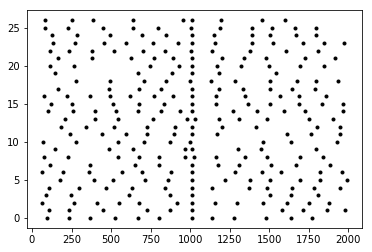

In [4]:
plot(spikemon_GoC1.t/ms, spikemon_GoC1.i, '.k')

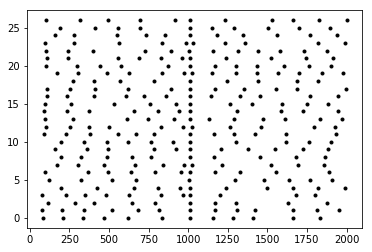

In [5]:
plot(spikemon_GoC2.t/ms, spikemon_GoC2.i, '.k')

The mossy fiber connects are not held constant in this scenario, however, the baseline firing of the cells are not constant. Yet, is flawed assumption; look at the first spike times across all cells and check for similarity. 

In [6]:
dfgoc1 = pd.DataFrame({'GoC':spikemon_GoC1.i, 'spk_t': spikemon_GoC1.t/ms})
dfgoc1.sort_values('spk_t', inplace=True)
dfgoc2 = pd.DataFrame({'GoC':spikemon_GoC2.i, 'spk_t': spikemon_GoC2.t/ms})
dfgoc2.sort_values('spk_t', inplace=True)

In [7]:
dfgoc1.head()

,GoC,spk_t
0,6,64.2
1,2,65.5
2,10,70.2
3,16,77.0
4,8,78.5


In [8]:
df_allgoc = pd.concat([dfgoc1.set_index(dfgoc1.index), dfgoc2.set_index(dfgoc2.index)], 
                      axis='columns', keys=['group1', 'group2'])

In [9]:
df_allgoc.head(10)

group1        group2       
     GoC  spk_t    GoC  spk_t
0    6.0   64.2      3   78.1
1    2.0   65.5      1   78.4
2   10.0   70.2      0   86.3
3   16.0   77.0     11   87.7
4    8.0   78.5     14   91.3
5   26.0   81.5     13   93.1
6   25.0   82.5     23   93.1
7    3.0   87.3     15   96.1
8    0.0   94.3      6   99.1
9   14.0  101.5     12  101.8

#### It seems that the stochastic current causes random spiking across the population.

In [10]:
GoC1_M.i

<synapses.i: array([  0,   0,   0, ..., 314, 314, 314], dtype=int32)>

In [11]:
GoC1_M.j

<synapses.j: array([ 4, 11, 14, ...,  7, 12, 22], dtype=int32)>

In [12]:
mf_goc1 = pd.DataFrame({'mf': GoC1_M.i[:],'GoC':GoC1_M.j[:]})
mf_goc2 = pd.DataFrame({'mf': GoC2_M.i[:],'GoC':GoC2_M.j[:]})

In [13]:
mf_goc1.head()

,mf,GoC
0,0,4
1,0,11
2,0,14
3,0,15
4,0,24


In [14]:
net_connections = pd.concat([mf_goc1.set_index(mf_goc1.index), mf_goc2.set_index(mf_goc2.index)], 
                            axis='columns', keys=['group1', 'group2'])

In [15]:
net_connections.head()

group1       group2    
      mf   GoC     mf GoC
0    0.0   4.0      0   4
1    0.0  11.0      0   7
2    0.0  14.0      0  10
3    0.0  15.0      0  12
4    0.0  24.0      0  18